# GANs In Action
## Chapter 2: Autoencoder
This is the accompanying code for the upcoming book _GANs in Action Deep Learning with Generative Adversarial Networks (GANs)_ by Manning Books. 

This tutorial was adapted from the [following tutorial](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py), which was published under MIT license.

## Why Colab?
Google Colabotary is an amazing way to run [Jupyter notebooks](http://jupyter.org) online, sprinkled on top with some Google goodness. We chose this environment, because it is compatible with the industry standard Jupyter notebooks but can be run by anyone with zero setup. But you are free to switch between the two commands as required.

## Why autoencoders? 
Well for that you'd need to buy the book ;) 

## Let's get started! 
And the only way to get started is with imports!

For reference, this code was checked with Keras as late as `2.2.4` and Tensorflow as late as `1.12.0`.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import keras

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

2026-02-26 13:34:43.545284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-26 13:34:43.575947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-26 13:34:44.276097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Next let's define some key variables.
We explain their meaning more in Chapter 2.

In [2]:
# defining the key parameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## Define sampling helper function. 

As per [PEP484](https://www.python.org/dev/peps/pep-0484/) we define typehints for this function. 

Args have to be a tuple, because we ultimately want to use this as a [Lambda function](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) or also called "Annoymous functions", but you didn't hear that from me ;) 

Remember that Lambda defines yet another function so we basically just defined two functions in the code below.

The implementation that follows is inspired by Branko Blagojevic in our book forums. [Thank you for this suggestion](https://forums.manning.com/posts/list/45083.page).

In [3]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = keras.ops.shape(z_mean)[0]
        epsilon = keras.random.normal(shape=(batch, latent_dim), stddev=epsilon_std)
        return z_mean + keras.ops.exp(0.5 * z_log_var) * epsilon

# Defining the encoder

In [ ]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer : 784 * 256 + 256 = 200960 parameters to be learned
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space : 256 * 2 + 2 = 514 parameters to be learned
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space : 256 * 2 + 2 = 514 parameters to be learned
z_log_var = Dense(latent_dim, name="log-variance")(h)
# sample z using the Sampling layer (replaces Lambda for Keras 3 compatibility)
z = Sampling()([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

I0000 00:00:1772073292.461809  141961 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13899 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 784)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding (Dense)    │ (None, 256)       │    200,960 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │        514 │ encoding[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log-variance        │ (None, 2)         │        514 │ encoding[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ log-variance[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

# Defining the decoder

In [5]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h (Dense)               │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_decoded (Dense)            │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

## Now let's define the Variational Autoencoder (VAE)
We use the encoder and decoder objects names from above. 

NOTE: 

**add_loss**:
- keras.Model (and keras.layers.Layer) provides add_loss() as a built-in method. 
- It lets you register auxiliary losses that are added to the main training loss automatically during model.fit(). 
- Because call() is expected to return the model output (the reconstruction here), not the loss. add_loss() is the Keras-idiomatic way to attach extra losses from inside a layer/model without changing the return value.

**KL Divergence loss**: 
- Kullback-Leibler (KL) Divergence loss $D_{KL}(P||Q)$ is a measure of how one probability distribution **Q** (typically the model's approximation) diverges from a target reference distribution **P**. 
- It quantifies the information lost when **Q** is used to represent **P**, frequently used in machine learning for classification, generative models (VAEs), and knowledge distillation to optimize probability distributions.

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, original_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.original_dim = original_dim

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        # Add KL divergence loss inside call() — the Keras 3 way
        kl_loss = -0.5 * keras.ops.sum(
            1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
            axis=-1)
        self.add_loss(keras.ops.mean(kl_loss))
        return reconstruction

vae = VAE(encoder, decoder, original_dim, name="vae")

## Colab hints
In the same way as with Jupyter notebook, we can ask for help if we do not know an object and it shows us the doc string. In case this was a suprise, or would like to know more about Colab, everyone gets "Intro to Colab" automatically into their GDrive when they start using Colab.

In [13]:
Model??

## Read the doc string!
We find out that Model inherits from `Container` and is the way that Keras likes to thing of a fully parametrized model, similar to [sklearn](http://scikit-learn.org/stable/index.html) that gives you loads of useful methods that you can read about in the doc string. For data scientists, this should put you into well understood territory.

## Define the losses and run the model!
We touch on [KL loss](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) (`xent_loss`) throughout the book, but these do not need to be familiar terms, as long as you understand the notion of a loss in machine learning.

In [7]:
def xent_loss(x, x_decoded_mean):
    return original_dim * keras.losses.binary_crossentropy(x, x_decoded_mean)

vae.compile(optimizer='rmsprop', loss=xent_loss)

## Let's take a look at the Keras' representation of the model
We can see above that the model has roughly the structure we expect:

784-> `latent_dim` -> 2 Gaussian parameters -> `latent_dim` -> 768.

Plus some extra things on top.

## It would not be Data Science, without _data_.
Let's load and clean the only dataset there is, apparently: MNIST.


In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [9]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50


2026-02-26 13:35:26.388250: I external/local_xla/xla/service/service.cc:153] XLA service 0x7b4a700154e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-26 13:35:26.388262: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0
2026-02-26 13:35:26.418490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1772073326.512860  142353 cuda_dnn.cc:530] Loaded cuDNN version 91200
2026-02-26 13:35:26.546398: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2026-02-26 13:35:26.546486: W external/local_xla/xla/service/gpu

246/600 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 255.3393

I0000 00:00:1772073330.111830  142353 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 640us/step - loss: 189.8356
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 169.3477
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 166.0682
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 163.9613
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 162.5061
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 161.3127
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 160.2253
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 159.2344
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 158.2690
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 157.4569
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 156.7545
Epoch 12/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 156.1941
Epoch 13/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 155.6691
Epoch 14/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 155.1958
Epoch 15/50


## Next we grab just the "data-generating" part of the model. 
In the book we explained how we generate the new images in Figure 2.3.

We will now generate the Figure in 2.6. It shows generated latents are grouped neatly in a latent space.

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step 


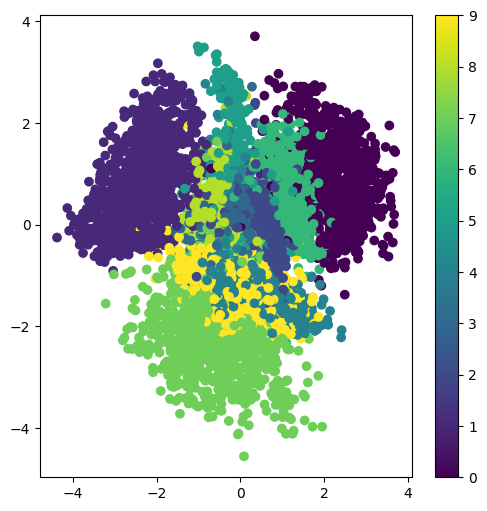

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Last but not least, let's generate Figure 2.7.

The only tricky part here is that we have to create a grid over which we interpolate. Which we do by using `np.linspace`, which enables us to move between `min` and `max` value in `step_size`. 

We then just generate a digit for each sample in the for loop and display!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

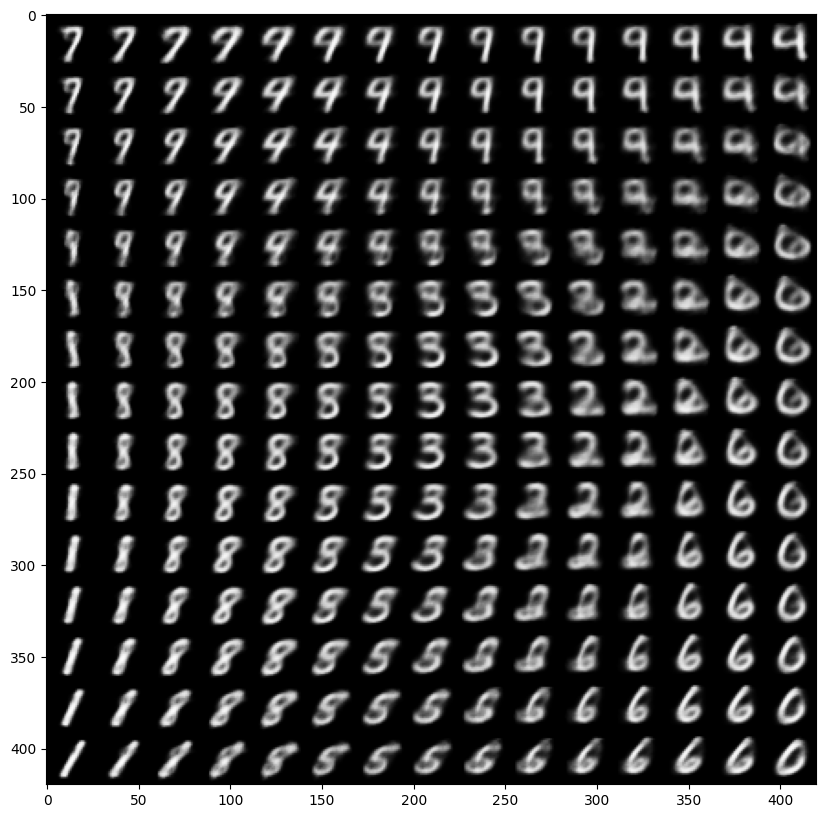

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()